### Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from ruptures import Pelt
import warnings
warnings.filterwarnings('ignore')

### Load and process the Brent oil price data with feature engineering

In [4]:
def load_and_process_data(file_path):
    """
    Load data, process date and price columns, and add engineered features.
    """
    # Load data
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.sort_values(by='Date')
    
    # Ensure there are no missing values
    df = df.dropna(subset=['Price'])
    df.set_index('Date', inplace=True)
    
    # Feature Engineering
    df['Returns'] = df['Price'].pct_change()  # Daily returns
    df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))  # Log returns
    df['Volatility'] = df['Returns'].rolling(window=21).std()  # 21-day rolling volatility
    df['Momentum'] = df['Price'].diff(5)  # 5-day momentum
    
    # Drop any NaN values that result from rolling calculations
    df.dropna(inplace=True)
    
    return df

file_path = 'C:/Users/Administrator/Documents/kifiya/Week_10/Raw_data/BrentOilPrices.csv'
df = load_and_process_data(file_path)
display(df.head())

,Price,Returns,Log_Returns,Volatility,Momentum
Date,,,,,
1987-06-19,19.05,0.000000,0.000000,0.004308,0.37
1987-06-22,19.10,0.002625,0.002621,0.003544,0.32
1987-06-23,18.90,-0.010471,-0.010526,0.004313,0.00
1987-06-24,18.75,-0.007937,-0.007968,0.004698,-0.28
1987-06-25,18.70,-0.002667,-0.002670,0.004736,-0.35


## Exploratory Data Analysis (EDA) 

### Plot the time series of Brent oil prices and engineered features.

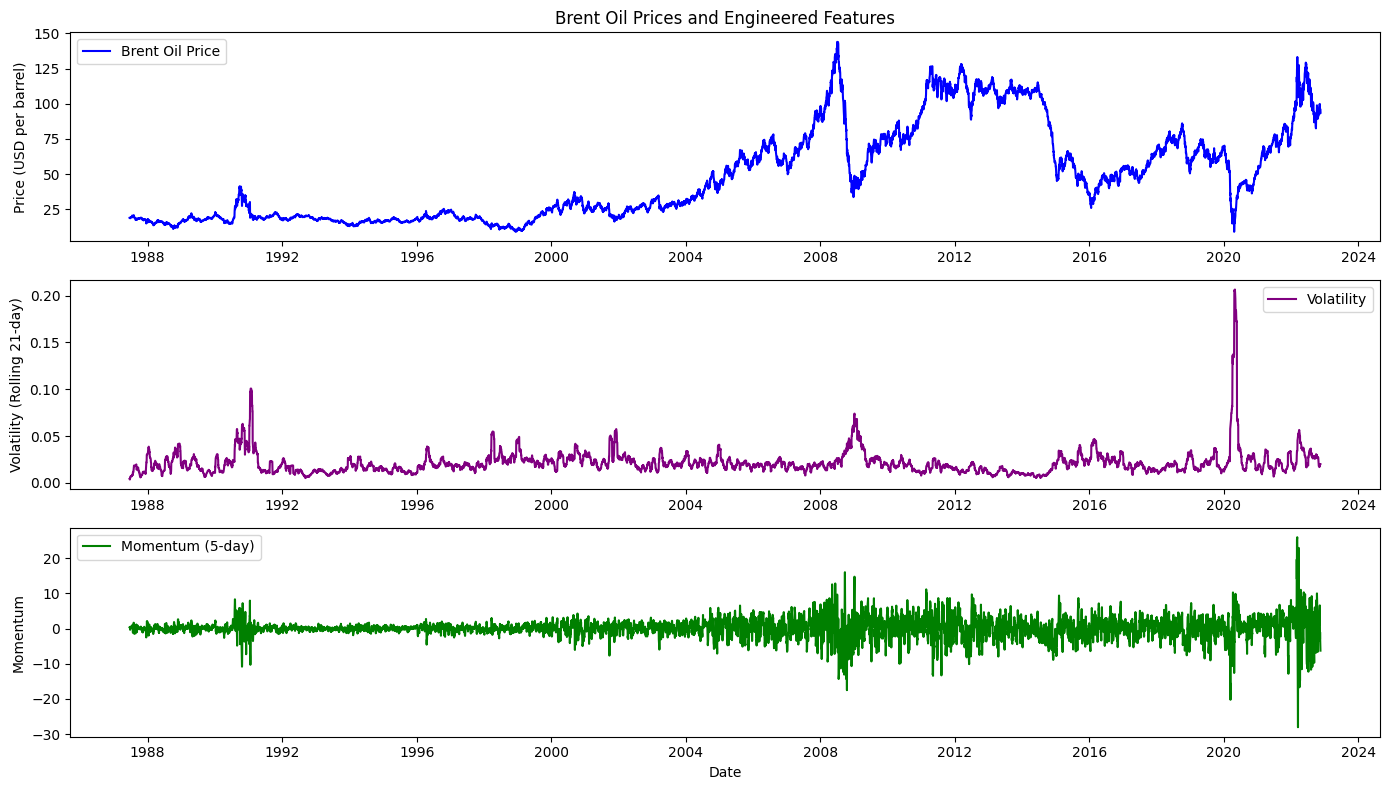

In [5]:
def plot_time_series(df):
    
    plt.figure(figsize=(14, 8))
    
    # Plot Price
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Price'], color='blue', label='Brent Oil Price')
    plt.title("Brent Oil Prices and Engineered Features")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()

    # Plot Volatility
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['Volatility'], color='purple', label='Volatility')
    plt.ylabel("Volatility (Rolling 21-day)")
    plt.legend()
    
    # Plot Momentum
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['Momentum'], color='green', label='Momentum (5-day)')
    plt.xlabel("Date")
    plt.ylabel("Momentum")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 
plot_time_series(df)

### Plot ACF and PACF for time series analysis.

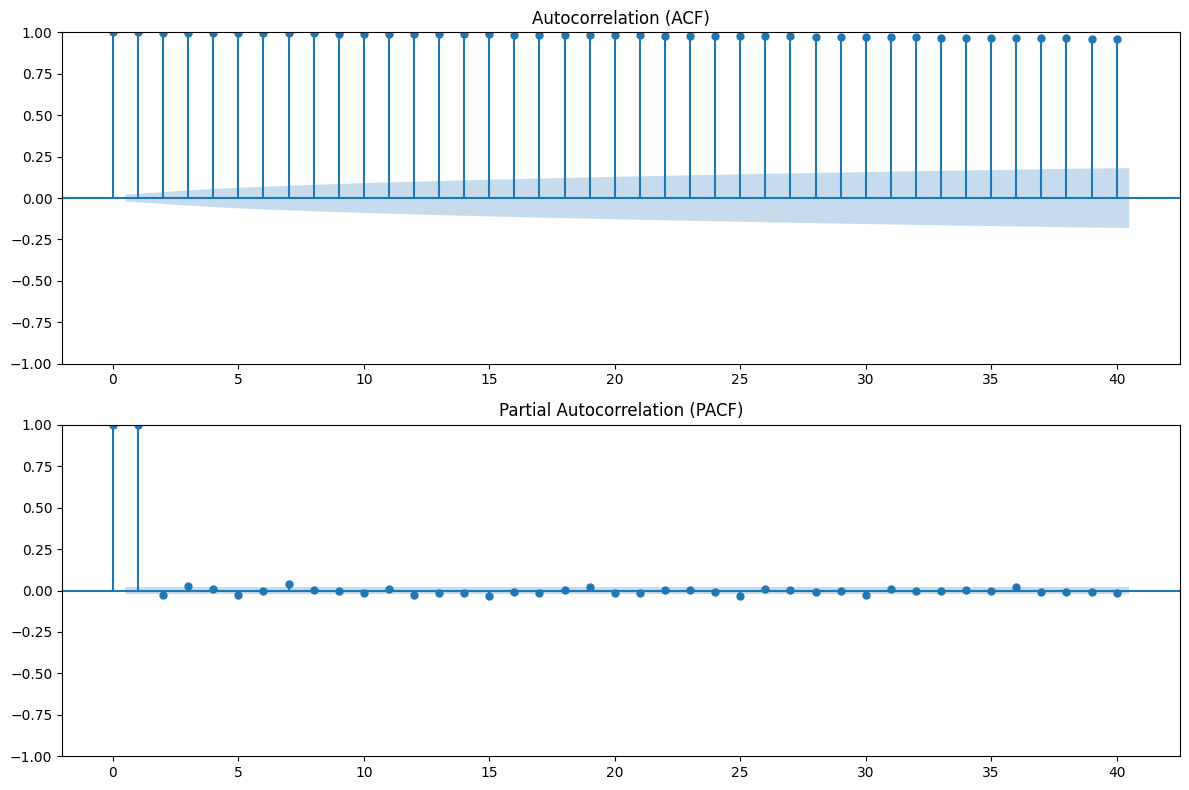

In [6]:
def plot_acf_pacf(df, column='Price'):
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[column], ax=ax[0])
    plot_pacf(df[column], ax=ax[1])
    ax[0].set_title("Autocorrelation (ACF)")
    ax[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()


plot_acf_pacf(df)

### Plot a heatmap to show correlation among features.

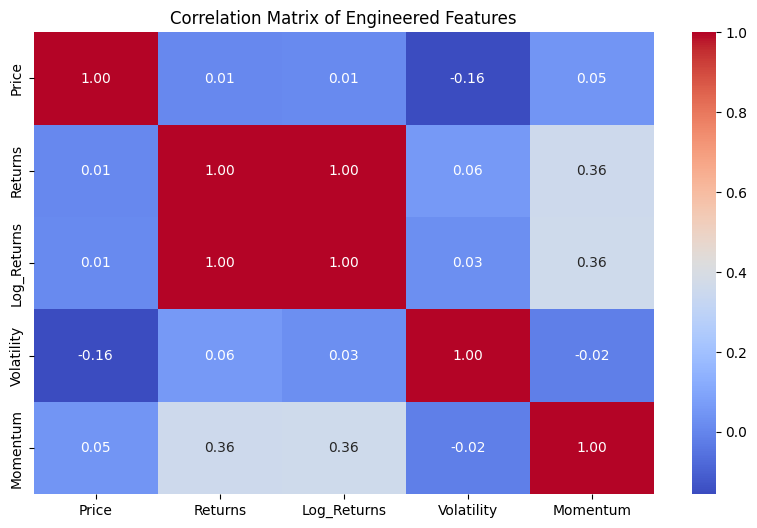

In [7]:
def correlation_analysis(df):
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Engineered Features")
    plt.show()

correlation_analysis(df)

###  Visualize distributions of key features: Returns, Log Returns, and Volatility.

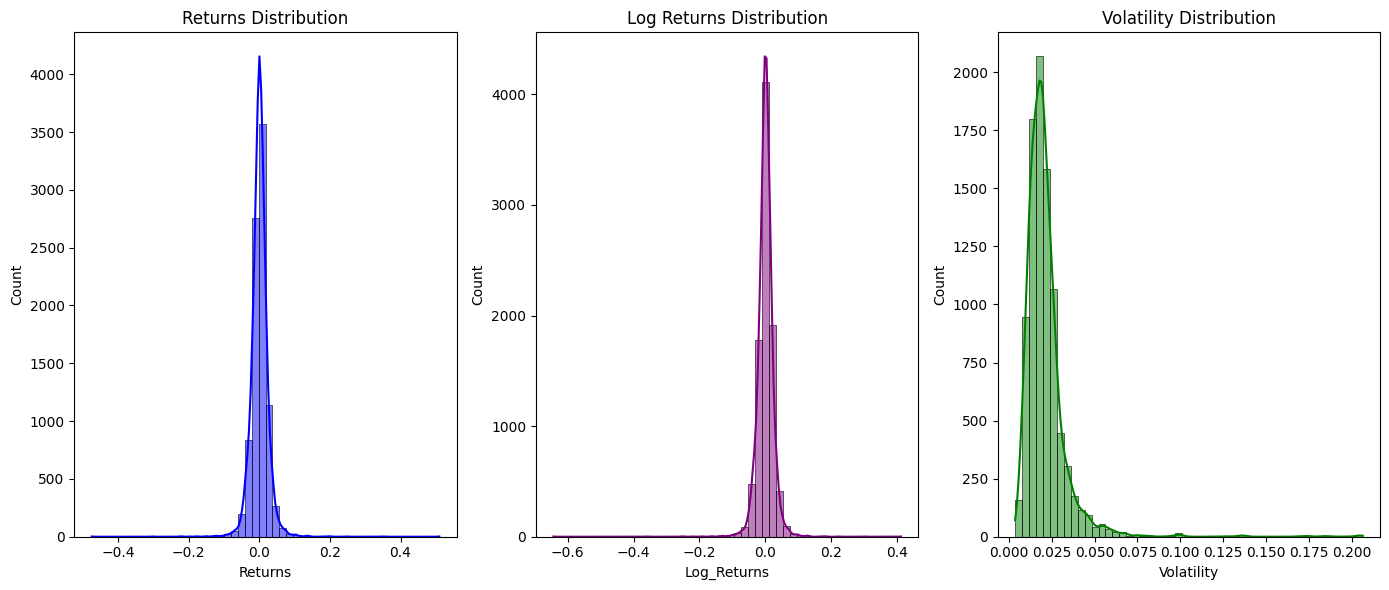

In [8]:

# Distribution Analysis
def distribution_analysis(df):
    
    plt.figure(figsize=(14, 6))
    
    # Returns Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df['Returns'], bins=50, color='blue', kde=True)
    plt.title("Returns Distribution")

    # Log Returns Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(df['Log_Returns'], bins=50, color='purple', kde=True)
    plt.title("Log Returns Distribution")
    
    # Volatility Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df['Volatility'], bins=50, color='green', kde=True)
    plt.title("Volatility Distribution")
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

### Perform seasonal decomposition to analyze trends, seasonality, and residuals with a wider layout.

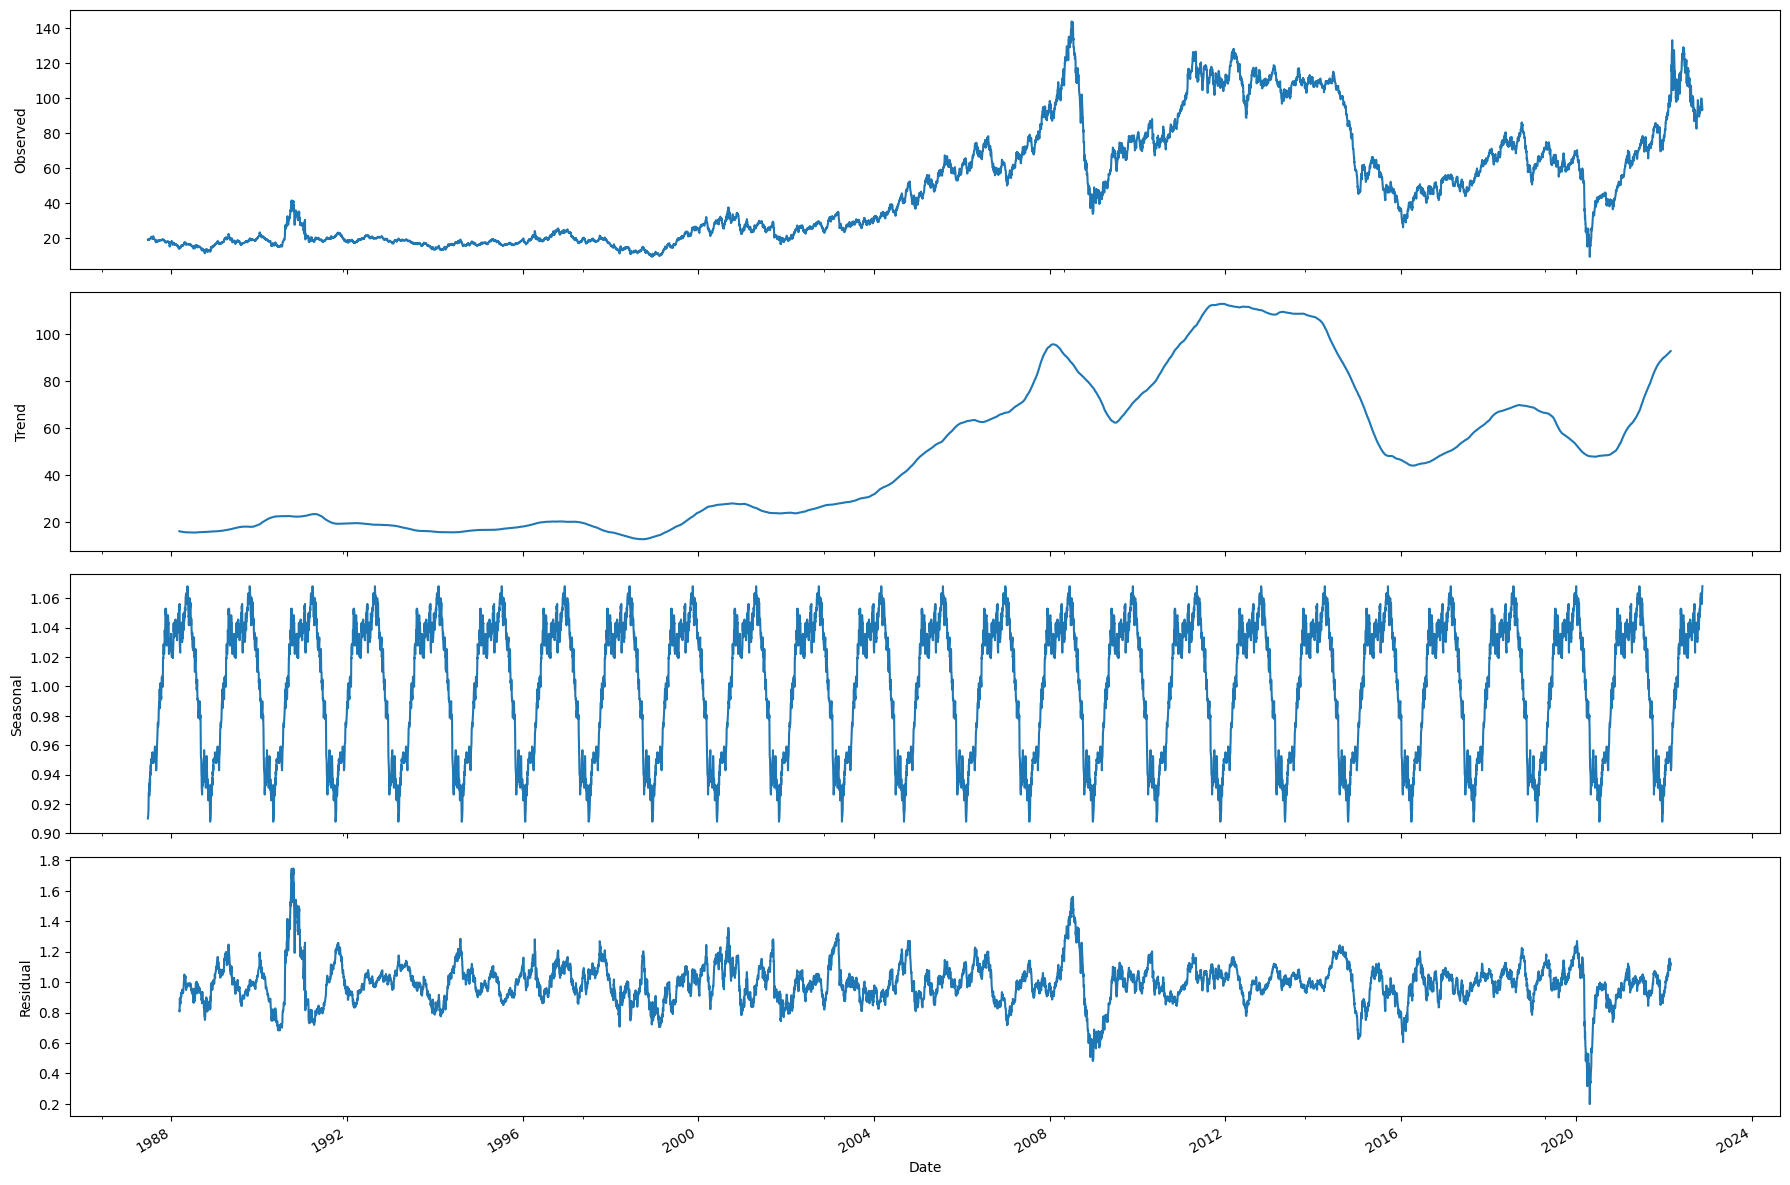

In [9]:
# Seasonality Analysis
def seasonality_analysis(df):
   
    decomposition = seasonal_decompose(df['Price'], model='multiplicative', period=365)

    # Set up a wider figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # Plot each component with wider axes
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

seasonality_analysis(df)

###  Calculate Value at Risk (VaR) and Expected Shortfall (ES) for returns.

In [10]:
# Risk Metrics Calculation
def calculate_risk_metrics(df, confidence_level=0.05):
 
    var = np.percentile(df['Returns'].dropna(), 100 * confidence_level)
    es = df['Returns'][df['Returns'] <= var].mean()
    
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var:.4f}")
    print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es:.4f}")


calculate_risk_metrics(df)

Value at Risk (VaR) at 5.0% confidence level: -0.0358
Expected Shortfall (ES) at 5.0% confidence level: -0.0546


### Calculate rolling correlation between volatility and returns.

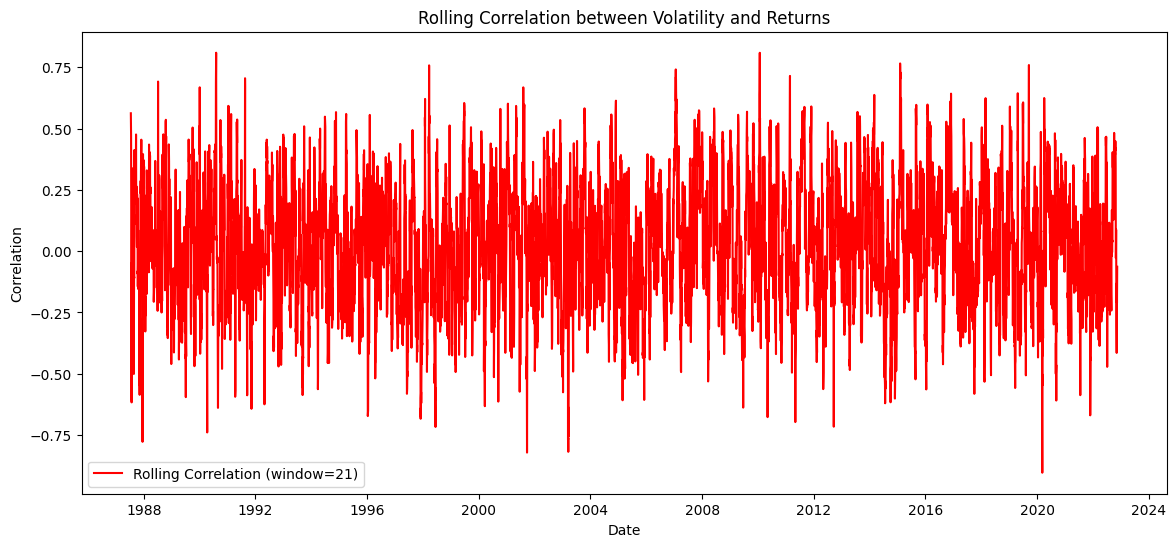

In [11]:
# Rolling Correlation
def rolling_correlation(df, window=21):
  
    df['Rolling_Corr'] = df['Volatility'].rolling(window).corr(df['Returns'])
    
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Rolling_Corr'], color='red', label=f'Rolling Correlation (window={window})')
    plt.title("Rolling Correlation between Volatility and Returns")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.legend()
    plt.show()

rolling_correlation(df)

### Perform the Augmented Dickey-Fuller test for stationarity.

In [12]:
def check_stationarity(df, column='Price'):
    
    result = adfuller(df[column])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary. Differencing may be needed.")


# Summary statistics
print("Descriptive statistics of Brent Oil Prices:")
display(df['Price'].describe())
check_stationarity(df)


Descriptive statistics of Brent Oil Prices:


count    8990.000000
mean       48.490186
std        32.867039
min         9.100000
25%        19.080000
50%        38.990000
75%        70.235000
max       143.950000
Name: Price, dtype: float64

ADF Statistic: -1.986246157536638
p-value: 0.29263604948116323
The data is non-stationary. Differencing may be needed.


## Understanding the Model and Data

### Fit ARIMA model and print summary.

In [13]:
# Define ARIMA Model
def arima_model(df, column='Price', p=1, d=1, q=1):
 
    model = ARIMA(df[column], order=(p, d, q))
    arima_result = model.fit()
    print(arima_result.summary())
    return arima_result

# Step 2: Model the data with ARIMA and GARCH
print("Fitting ARIMA model...")
arima_result = arima_model(df)

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8990
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14520.492
Date:                Sat, 09 Nov 2024   AIC                          29046.985
Time:                        21:21:47   BIC                          29068.296
Sample:                             0   HQIC                         29054.237
                               - 8990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.160     -2.147      0.032      -0.656      -0.030
ma.L1          0.3712      0.158      2.353      0.019       0.062       0.680
sigma2         1.4812      0.

### Fit GARCH model to capture volatility.

In [14]:
# Define GARCH Model
def garch_model(df):
   
    model = arch_model(df['Log_Returns'].dropna(), vol='Garch', p=1, q=1)
    garch_result = model.fit(disp="off")
    print(garch_result.summary())
    return garch_result

print("Fitting GARCH model for volatility analysis...")
garch_result = garch_model(df)


Fitting GARCH model for volatility analysis...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                22114.2
Distribution:                  Normal   AIC:                          -44220.4
Method:            Maximum Likelihood   BIC:                          -44192.0
                                        No. Observations:                 8990
Date:                Sat, Nov 09 2024   Df Residuals:                     8989
Time:                        21:21:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         

### Plot residuals and ACF of residuals to check for white noise.

In [15]:
 #Residual Analysis for ARIMA and GARCH Models
def residual_analysis(model_results, title="Model Residuals"):
   
    residuals = model_results.resid
    plt.figure(figsize=(12, 5))
    
    # Plot Residuals
    plt.subplot(1, 2, 1)
    plt.plot(residuals, color='blue')
    plt.title(f"{title} - Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    
    # Plot ACF of Residuals
    plt.subplot(1, 2, 2)
    plot_acf(residuals.dropna(), ax=plt.gca())
    plt.title("Residuals Autocorrelation")
    
    plt.tight_layout()
    plt.show()


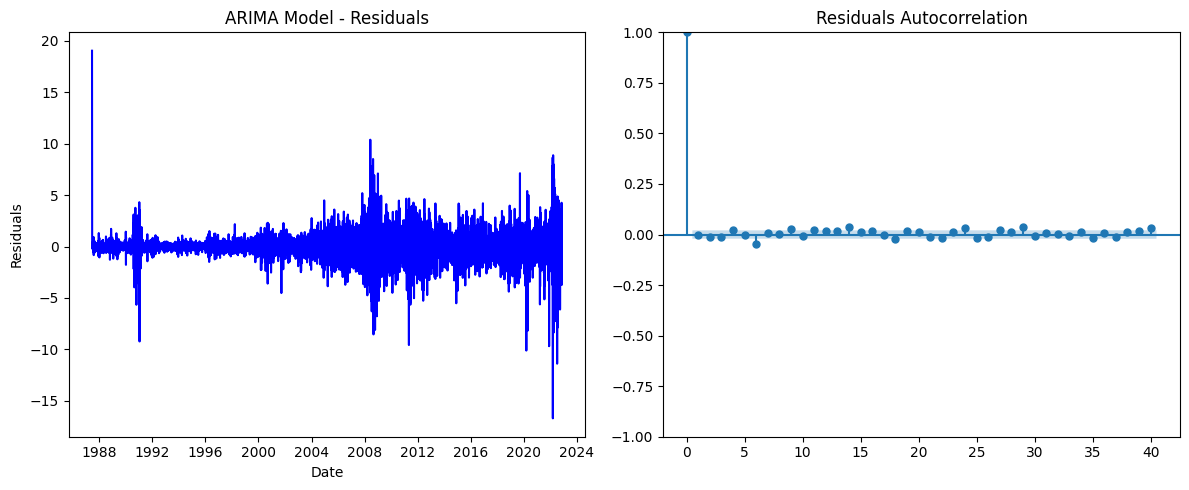

In [16]:
 # Residual Analysis for ARIMA
residual_analysis(arima_result, title="ARIMA Model")

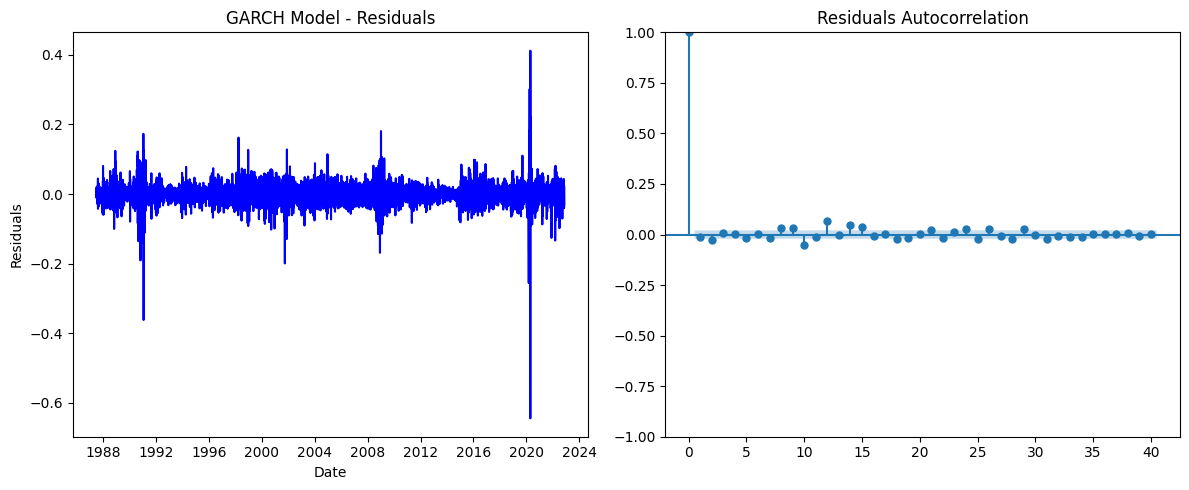

In [17]:
 # GARCH Model on Log Returns
residual_analysis(garch_result, title="GARCH Model")

### # Event Data Preparation

In [18]:
# Event Data Preparation
def create_event_dataframe():
    """
    Create a DataFrame for significant events related to oil price changes.
    """
    events_data = [
    {"Date": "1987-10-19", "Event": "Black Monday", "Type": "Economic"},
    {"Date": "1988-07-03", "Event": "USS Vincennes Incident (Iran Air Flight 655)", "Type": "Geopolitical"},
    {"Date": "1989-01-01", "Event": "End of Cold War", "Type": "Geopolitical"},
    {"Date": "1990-08-02", "Event": "Iraq Invades Kuwait", "Type": "Geopolitical"},
    {"Date": "1990-08-06", "Event": "U.N. Sanctions on Iraq", "Type": "Geopolitical"},
    {"Date": "1991-01-17", "Event": "Gulf War", "Type": "Geopolitical"},
    {"Date": "1991-12-26", "Event": "Collapse of the Soviet Union", "Type": "Geopolitical"},
    {"Date": "1993-01-01", "Event": "North Sea Oil Production Expansion", "Type": "Supply"},
    {"Date": "1993-03-27", "Event": "OPEC Agreement to Cut Production", "Type": "OPEC"},
    {"Date": "1996-04-30", "Event": "Sanctions on Libya", "Type": "Geopolitical"},
    {"Date": "1997-01-01", "Event": "Asian Financial Crisis", "Type": "Economic"},
    {"Date": "1998-01-01", "Event": "Venezuela’s Political Crisis", "Type": "Geopolitical"},
    {"Date": "1998-12-31", "Event": "BP-Amoco Merger", "Type": "Industry"},
    {"Date": "1999-03-24", "Event": "NATO Bombing of Yugoslavia", "Type": "Geopolitical"},
    {"Date": "2000-03-01", "Event": "OPEC Price Band Mechanism", "Type": "OPEC"},
    {"Date": "2000-09-28", "Event": "Second Intifada", "Type": "Geopolitical"},
    {"Date": "2001-09-11", "Event": "September 11 Attacks", "Type": "Geopolitical"},
    {"Date": "2002-01-01", "Event": "Iraq-U.S. Tensions", "Type": "Geopolitical"},
    {"Date": "2003-03-20", "Event": "U.S. Invasion of Iraq", "Type": "Geopolitical"},
    {"Date": "2003-01-01", "Event": "ChevronTexaco Merger", "Type": "Industry"},
    {"Date": "2004-01-01", "Event": "Rising Demand from China", "Type": "Demand"},
    {"Date": "2005-08-01", "Event": "Hurricane Katrina", "Type": "Natural Disaster"},
    {"Date": "2005-01-01", "Event": "China’s Strategic Oil Reserves", "Type": "Demand"},
    {"Date": "2006-01-01", "Event": "Niger Delta Militants", "Type": "Geopolitical"},
    {"Date": "2007-01-01", "Event": "Baku-Tbilisi-Ceyhan Pipeline Completion", "Type": "Supply"},
    {"Date": "2008-01-01", "Event": "Global Financial Crisis", "Type": "Economic"},
    {"Date": "2008-01-01", "Event": "U.S. Dollar Devaluation", "Type": "Economic"},
    {"Date": "2010-04-20", "Event": "Deepwater Horizon Oil Spill", "Type": "Natural Disaster"},
    {"Date": "2010-01-01", "Event": "Russia Expands Energy Ties with China", "Type": "Industry"},
    {"Date": "2011-01-01", "Event": "Arab Spring", "Type": "Geopolitical"},
    {"Date": "2011-03-11", "Event": "Japanese Earthquake and Fukushima Disaster", "Type": "Natural Disaster"},
    {"Date": "2012-01-01", "Event": "Sanctions on Iran", "Type": "Geopolitical"},
    {"Date": "2012-01-01", "Event": "Saudi Arabia’s Increased Production", "Type": "Supply"},
    {"Date": "2013-01-01", "Event": "North American Shale Boom", "Type": "Supply"},
    {"Date": "2014-02-01", "Event": "Russia-Ukraine Conflict", "Type": "Geopolitical"},
    {"Date": "2014-06-01", "Event": "Oil Price Collapse", "Type": "Economic"},
    {"Date": "2015-01-01", "Event": "China’s Economic Slowdown", "Type": "Economic"},
    {"Date": "2016-05-01", "Event": "Canadian Wildfires", "Type": "Natural Disaster"},
    {"Date": "2017-01-01", "Event": "U.S. Oil Exports to Asia", "Type": "Industry"},
    {"Date": "2018-01-01", "Event": "Turkey-U.S. Sanctions", "Type": "Geopolitical"},
    {"Date": "2019-01-01", "Event": "U.S.-China Trade War", "Type": "Economic"},
    {"Date": "2020-01-01", "Event": "COVID-19 Pandemic", "Type": "Global Crisis"},
    {"Date": "2020-03-01", "Event": "OPEC+ Price War", "Type": "OPEC"},
    {"Date": "2020-04-01", "Event": "Oil Storage Crisis", "Type": "Supply"},
    {"Date": "2021-02-01", "Event": "Texas Winter Storm", "Type": "Natural Disaster"},
    {"Date": "2021-01-01", "Event": "Global Supply Chain Disruptions", "Type": "Economic"},
    {"Date": "2021-12-01", "Event": "Omicron Variant Emergence", "Type": "Global Crisis"},
    {"Date": "2022-02-24", "Event": "Russia-Ukraine War", "Type": "Geopolitical"},
    {"Date": "2022-09-26", "Event": "Nord Stream Pipeline Explosions", "Type": "Geopolitical"},
    {"Date": "2022-11-01", "Event": "G7 Oil Price Cap on Russian Exports", "Type": "Economic"},
    {"Date": "2023-07-01", "Event": "Saudi-Russia Oil Cuts", "Type": "OPEC"},
    {"Date": "2023-01-01", "Event": "China’s Post-COVID Economic Recovery", "Type": "Demand"}
]
    
    events_df = pd.DataFrame(events_data)
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    return events_df

### Overlay events on the Brent oil price timeline.

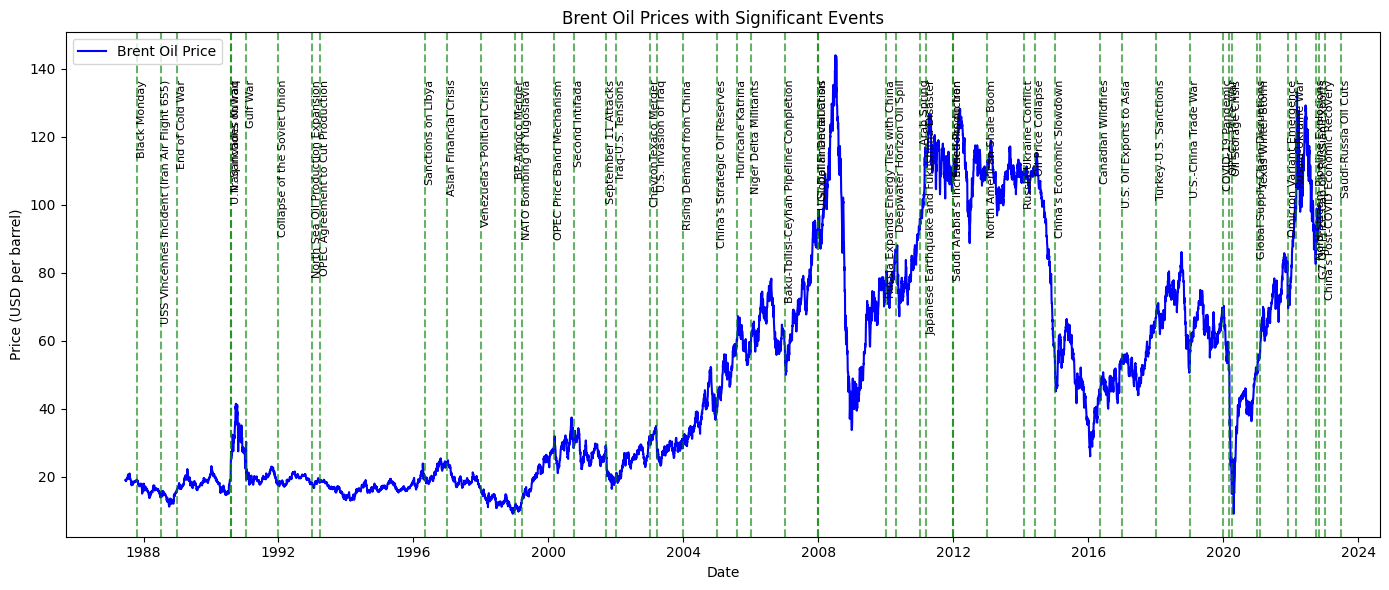

In [19]:
def plot_with_events(df, events_df):
   
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
    
    for _, row in events_df.iterrows():
        plt.axvline(row['Date'], color='green', linestyle='--', alpha=0.6)
        plt.text(row['Date'], df['Price'].max() * 0.95, row['Event'], rotation=90, verticalalignment='top', fontsize=8)
    
    plt.title("Brent Oil Prices with Significant Events")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.tight_layout()
    plt.show()


 # Step 3: Overlay events on the time series
events_df = create_event_dataframe()
plot_with_events(df, events_df)

### Calculate the average volatility and returns around event dates to quantify impact.

In [21]:

# Event Impact on Volatility and Returns
def event_impact_analysis(df, events_df):
 
    impacts = []
    for _, event in events_df.iterrows():
        date = event['Date']
        # Define a window around the event date
        before = df.loc[date - pd.Timedelta(days=5):date - pd.Timedelta(days=1)]
        after = df.loc[date:date + pd.Timedelta(days=5)]
       
        
        # Calculate average volatility and returns before and after the event
        before_volatility = before['Volatility'].mean()
        after_volatility = after['Volatility'].mean()
        before_return = before['Returns'].mean()
        after_return = after['Returns'].mean()
        before_price= before['Price'].mean()
        after_price= after['Price'].mean()
        
        impacts.append({
            "Event": event['Event'],
            "Date": date,
            "before_price": before_price,
            "after_price": after_price,
            "Before_Volatility": before_volatility,
            "After_Volatility": after_volatility,
            "Before_Return": before_return,
            "After_Return": after_return,
        })
    
    impact_df = pd.DataFrame(impacts)
    print("Event Impact Analysis:")
    display(impact_df)
    return impact_df

 # Event Impact Analysis
impact_df = event_impact_analysis(df, events_df)

impact_df.to_csv("C:/Users/Administrator/Documents/kifiya/Week_10/Raw_data/events_impact.csv", index=True)

Event Impact Analysis:


,Event,Date,before_price,after_price,Before_Volatility,After_Volatility,Before_Return,After_Return
0,Black Monday,1987-10-19,18.786667,18.984000,0.006125,0.007413,0.008046,-0.000156
1,USS Vincennes Incident (Iran Air Flight 655),1988-07-03,14.377500,14.616000,0.013149,0.018075,-0.016807,0.015863
2,End of Cold War,1989-01-01,16.120000,16.590000,0.020007,0.017449,0.013917,0.009428
3,Iraq Invades Kuwait,1990-08-02,19.380000,25.252500,0.022837,0.036841,0.015649,0.083503
4,U.N. Sanctions on Iraq,1990-08-06,22.103333,26.396000,0.029700,0.044070,0.079101,0.019587
5,Gulf War,1991-01-17,29.693333,20.045000,0.067608,0.097266,0.053139,-0.078305
6,Collapse of the Soviet Union,1991-12-26,17.690000,17.820000,0.020105,0.020086,-0.020493,-0.000373
7,North Sea Oil Production Expansion,1993-01-01,17.870000,17.580000,0.013313,0.011449,-0.007867,-0.005988
8,OPEC Agreement to Cut Production,1993-03-27,18.418000,18.695000,0.011937,0.012137,-0.000246,0.005798
9,Sanctions on Libya,1996-04-30,20.150000,19.320000,0.037958,0.036981,-0.011024,-0.008213


### change point detection

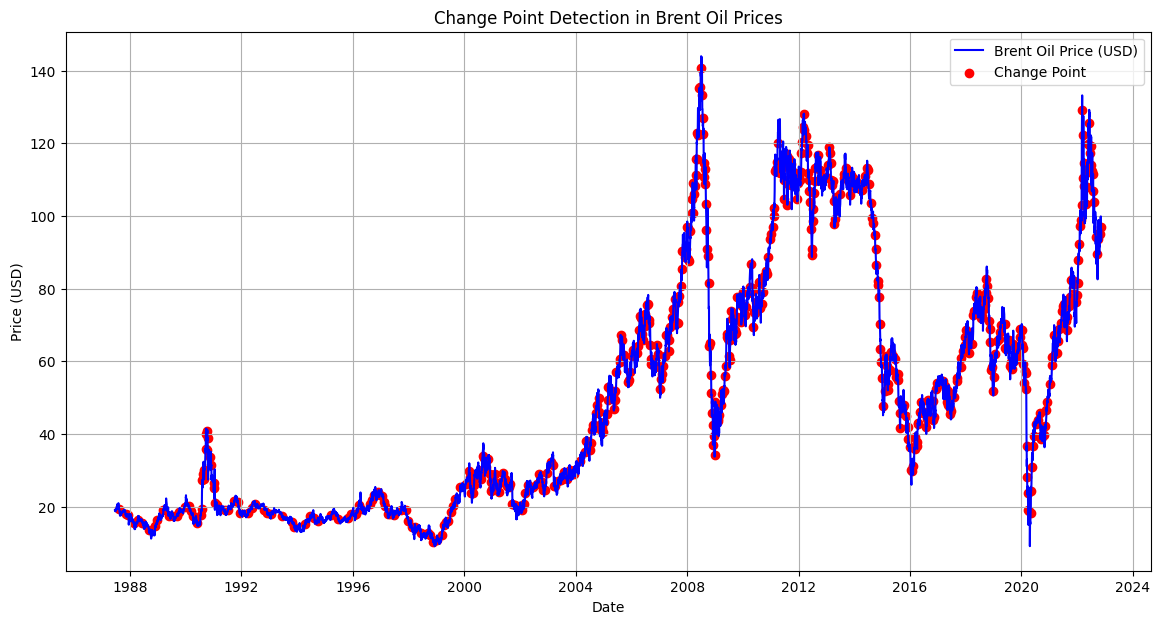

In [22]:
# Prepare the price data for change point detection
price_values = df['Price'].values

# Apply PELT to detect change points in the series
algo = Pelt(model="l2").fit(price_values)
change_points = algo.predict(pen=10)  # Adjust penalty to tune sensitivity

# Plot Brent Oil Price with detected change points highlighted
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price (USD)', color='blue')
plt.scatter(df.index[change_points[:-1]], df['Price'].iloc[change_points[:-1]], color='red', label='Change Point')
plt.legend()
plt.title('Change Point Detection in Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


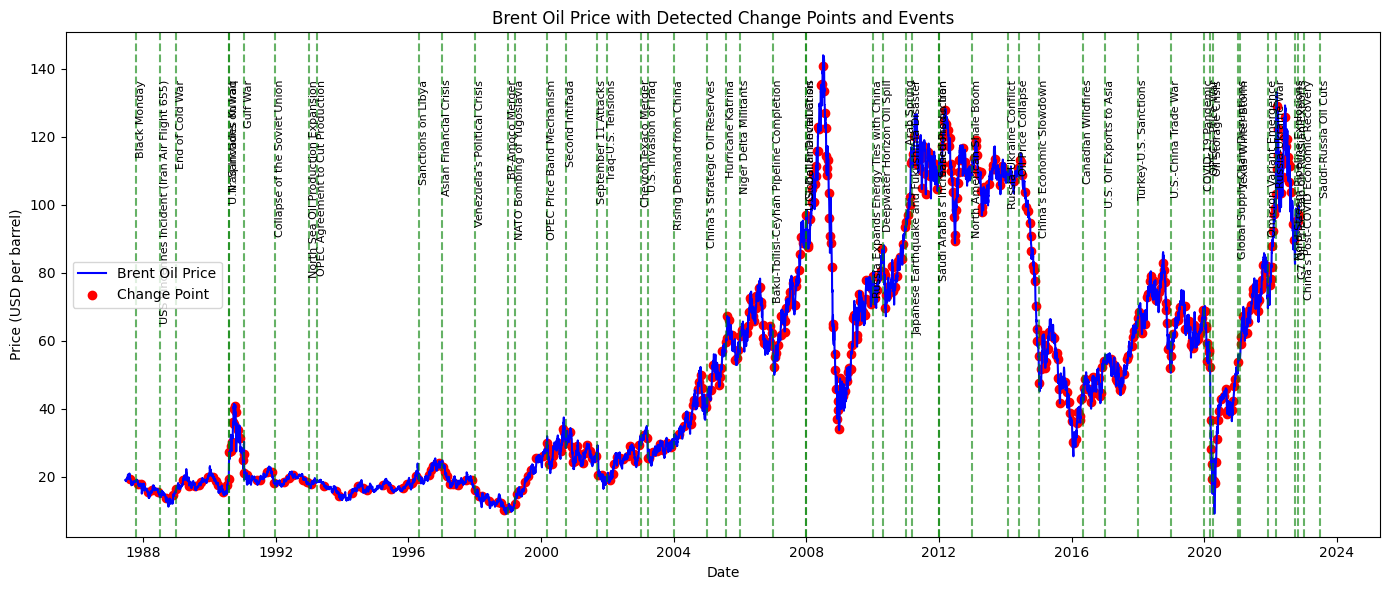

In [23]:
def plot_with_events_with_change_points(df, events_df):
   
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
    
    for _, row in events_df.iterrows():
        plt.axvline(row['Date'], color='green', linestyle='--', alpha=0.6)
        plt.text(row['Date'], df['Price'].max() * 0.95, row['Event'], rotation=90, verticalalignment='top', fontsize=8)

    plt.scatter(df.index[change_points[:-1]], df['Price'].iloc[change_points[:-1]], color='red', label='Change Point')
    plt.title('Brent Oil Price with Detected Change Points and Events')
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_with_events_with_change_points(df, events_df)

### Saving processed data

In [25]:
df.to_csv("C:/Users/Administrator/Documents/kifiya/Week_10/Raw_data/preproccessed_brent_oil_prices.csv", index=True)
display(df.head())

,Price,Returns,Log_Returns,Volatility,Momentum,Rolling_Corr
Date,,,,,,
1987-06-19,19.05,0.000000,0.000000,0.004308,0.37,NaN
1987-06-22,19.10,0.002625,0.002621,0.003544,0.32,NaN
1987-06-23,18.90,-0.010471,-0.010526,0.004313,0.00,NaN
1987-06-24,18.75,-0.007937,-0.007968,0.004698,-0.28,NaN
1987-06-25,18.70,-0.002667,-0.002670,0.004736,-0.35,NaN
